In [1]:
import nfl_data_py as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

pd.set_option('display.max_columns', 7)

In [2]:
seasons = [2020, 2022]

In [3]:
data = pd.concat([nfl.import_pbp_data(seasons).assign(season=season) for season in range(1999, 2022)])

2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.
2020 done.
2022 done.
Downcasting floats.


In [4]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,...,-0.083657,-0.013547,-0.013547
1,ARI,2000,2,...,0.390322,0.062389,0.062389
2,ARI,2000,3,...,-0.224378,0.008803,0.008803
3,ARI,2000,4,...,0.178663,0.040384,0.040384
4,ARI,2000,5,...,0.340035,0.095869,0.095869


In [5]:
epa

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,...,-0.083657,-0.013547,-0.013547
1,ARI,2000,2,...,0.390322,0.062389,0.062389
2,ARI,2000,3,...,-0.224378,0.008803,0.008803
3,ARI,2000,4,...,0.178663,0.040384,0.040384
4,ARI,2000,5,...,0.340035,0.095869,0.095869
...,...,...,...,...,...,...,...
11831,WAS,2021,14,...,-0.044324,-0.072347,-0.053130
11832,WAS,2021,15,...,-0.466945,-0.144093,-0.102415
11833,WAS,2021,16,...,-0.212840,-0.156592,-0.110913
11834,WAS,2021,17,...,-0.239111,-0.171596,-0.120983


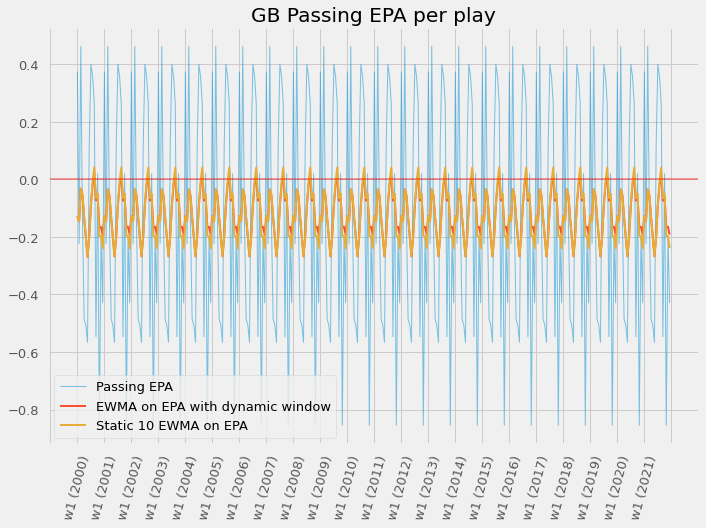

In [41]:
tm = epa.loc[epa['team'] == 'NE', :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title('GB Passing EPA per play')
plt.show();

In [17]:
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,...,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,SF,...,-0.083657,-0.013547,-0.013547
1,2000,1,DET,...,0.208879,0.208233,0.208233
2,2000,1,DET,...,-0.235649,0.078120,0.078120
3,2000,1,WAS,...,-0.235649,0.078120,0.078120
4,2000,1,BAL,...,0.269865,0.140717,0.140717


In [29]:
list(df)

['season',
 'week',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'home_team_win',
 'epa_rushing_offense_home',
 'epa_shifted_rushing_offense_home',
 'ewma_rushing_offense_home',
 'ewma_dynamic_window_rushing_offense_home',
 'epa_passing_offense_home',
 'epa_shifted_passing_offense_home',
 'ewma_passing_offense_home',
 'ewma_dynamic_window_passing_offense_home',
 'epa_rushing_defense_home',
 'epa_shifted_rushing_defense_home',
 'ewma_rushing_defense_home',
 'ewma_dynamic_window_rushing_defense_home',
 'epa_passing_defense_home',
 'epa_shifted_passing_defense_home',
 'ewma_passing_defense_home',
 'ewma_dynamic_window_passing_defense_home',
 'epa_rushing_offense_away',
 'epa_shifted_rushing_offense_away',
 'ewma_rushing_offense_away',
 'ewma_dynamic_window_rushing_offense_away',
 'epa_passing_offense_away',
 'epa_shifted_passing_offense_away',
 'ewma_passing_offense_away',
 'ewma_dynamic_window_passing_offense_away',
 'epa_rushing_defense_away',
 'epa_shifted_rushing_defense

In [18]:
target = 'home_team_win'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
for feature in features:
  print(feature)

ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away


In [19]:
df = df.dropna()

X = df.loc[df['season'] != 2020, features].values
y = df.loc[df['season'] != 2020, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [20]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))

Model Accuracy: 0.6825947410430226


In [21]:
print('Neg log loss:', np.mean(log_losses))

Neg log loss: -0.5997394690119279


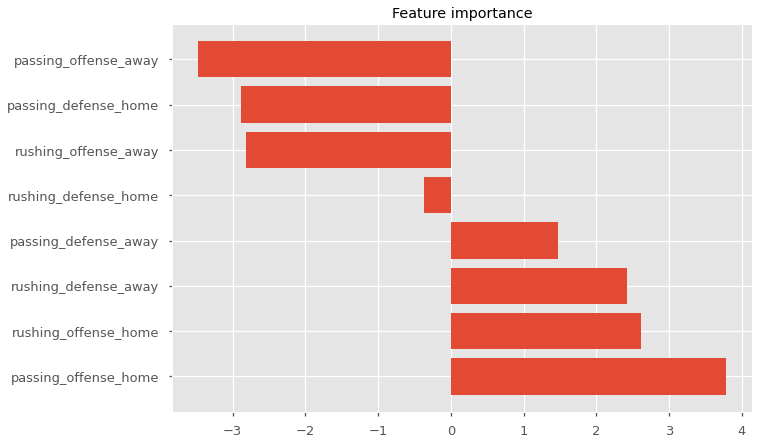

In [22]:
fig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted);
plt.show();

In [45]:
df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2020['actual_winner'] = df_2020.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2020['predicted_winner'] = df_2020.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2020['win_probability'] = df_2020.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2020['correct_prediction'] = (df_2020['predicted_winner'] == df_2020['actual_winner']).astype(int)

df_2020 = df_2020.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2020.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)

/Users/michaelmorton/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/michaelmorton/opt/anaconda3/envs/dev/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,KC,NYJ,8,KC,KC,0.940417,1
1,KC,DEN,13,KC,KC,0.923225,1
2,JAX,IND,1,IND,JAX,0.895132,0
3,MIA,NYJ,6,MIA,MIA,0.883560,1
4,GB,DET,2,GB,GB,0.878662,1
5,IND,CIN,6,IND,IND,0.878648,1
6,NYG,TB,8,TB,TB,0.870364,1
7,DET,GB,14,GB,GB,0.869141,1
8,NYJ,CLE,16,CLE,NYJ,0.866125,0
9,KC,LV,5,KC,LV,0.861404,0


In [33]:
from scipy import stats

In [37]:
x = df['epa_passing_defense_away'].values
y = df['ewma_dynamic_window_passing_defense_home'].values
x
y

array([-0.07489789,  0.45048191,  0.45048191, ..., -0.01176349,
        0.22869755,  0.20823269])

/Users/michaelmorton/opt/anaconda3/envs/dev/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/michaelmorton/opt/anaconda3/envs/dev/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


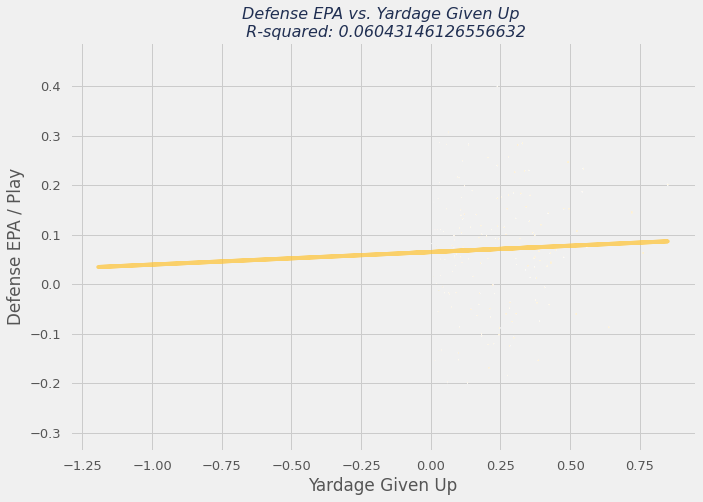

In [39]:
plt.style.use('fivethirtyeight')

x = df['epa_passing_defense_away'].values
y = df['ewma_dynamic_window_passing_defense_home'].values

m, b = np.polyfit(x, y, 1)
r_2 = stats.pearsonr(x, y)[0]

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(x, y, edgecolors='white', s=df['epa_passing_defense_away']/3, color='#ffc331')
ax.plot(x, x*m + b, alpha=0.7, lw=4, color='#ffc331')
ax.set_title(f'Defense EPA vs. Yardage Given Up \n R-squared: {r_2}', color='#202f52', fontstyle='italic', fontsize=16);
ax.set_xlabel('Yardage Given Up');
ax.set_ylabel('Defense EPA / Play');